In [1]:
import collections
import numpy as np
import random

# define class for representing a state (as seen by the Player)
State = collections.namedtuple('State', ['player_total', 'dealer_value_shown', 'has_usable_ace'])
map_state_to_idx = {v:k for k,v in enumerate([
    State(pt, dvs, hua) for pt in range(12, 22) for dvs in range(1, 11) for hua in (False, True)
])}


Card = collections.namedtuple('Card', ['rank', 'value'])

class BlackjackDeck:
    """Simplified deck for generating card draws."""
    def __init__(self):
        ranks = [str(n) for n in range(2, 11)] + list('JQKA')
        values = list(range(2, 11)) + [10]*3 + [11]
        self._cards = [Card(r,v) for r,v in zip(ranks, values)]

    def draw(self):
        return random.choice(self._cards)


DECK = BlackjackDeck()

class Q:
    """Helper class for representing an approximate action-value function
    Q(s,a). This class is primarily used for indexing action-value matrices
    with State (future: and Action) objects.
    """
    def __init__(self):
        self._Q = 1.0 * np.ones((200, 2))

    def __getitem__(self, key):
        state, action = key
        s_idx = map_state_to_idx[state]
        return self._Q[s_idx, action]
    
    def __setitem__(self, key, value):
        state, action = key
        s_idx = map_state_to_idx[state]
        self._Q[s_idx, action] = value


class Player:
    def __init__(self):
        self.Q_sa = Q()
        self.returns_sa = collections.defaultdict(list)
        self.reset()
    
    def reset(self):
        """Start a new game."""
        self.hand = [DECK.draw(), DECK.draw()]

    def policy(self, state: State):
        """Act in accordance with the current action-value function."""
        return np.argmax(self.Q_sa[state, :])

    @property
    def has_usable_ace(self):
        return 'A' in [h.rank for h in self.hand]

    @property
    def total(self):
        total_ = sum([h.value for h in self.hand])
        if total_ > 21 and self.has_usable_ace:
            total_ -= 10
        return total_

    def draw(self):
        self.hand.append(DECK.draw())

    @property
    def bust(self):
        return self.total > 21

    def __repr__(self):
        msg = "Player("
        msg += ', '.join([h.rank for h in self.hand])
        msg += ')'
        return msg
    
    @property
    def has_natural(self):
        if len(self.hand) == 2:
            ranks = [h.rank for h in self.hand]
            vals = [h.value for h in self.hand]
            if 'A' in ranks and 10 in vals:
                return True
        return False



class Dealer:
    def __init__(self):
        self.reset()

    @property
    def shown(self) -> int:
        if self.hand[0].rank == 'A':
            return 1
        else:
            return self.hand[0].value

    @property
    def has_usable_ace(self):
        return 'A' in [h.rank for h in self.hand]

    @property
    def total(self):
        total_ = sum([h.value for h in self.hand])
        if total_ > 21 and self.has_usable_ace:
            total_ -= 10
        return total_
    
    def draw(self):
        self.hand.append(DECK.draw())

    @property
    def bust(self):
        return self.total > 21

    def reset(self):
        self.hand = [DECK.draw(), DECK.draw()]

    def __repr__(self):
        msg = "Dealer("
        msg += ', '.join([h.rank for h in self.hand])
        msg += ')'
        return msg
    
    def policy(self):
        """Static policy for the dealer."""
        if self.total < 17:
            return 'hit'
        return 'stick'
    
    @property
    def has_natural(self):
        if len(self.hand) == 2:
            ranks = [h.rank for h in self.hand]
            vals = [h.value for h in self.hand]
            if 'A' in ranks and 10 in vals:
                return True
        return False

In [2]:
def env_step(player, action, dealer) -> tuple[float, bool]: # reward, terminated
    if action == 0: # hit
        player.draw()
        if player.bust:
            return (-1.0, True) # game over
        else:
            return (0.0, False) # game continues

    elif action == 1: # stay
        # dealer takes turn
        while dealer.policy() == 'hit':
            dealer.draw()
        if dealer.bust:
            return (1.0, True)
        else:
            # compare player's and dealer's hands
            if player.total > dealer.total:
                r = 1.0
            elif player.total < dealer.total:
                r = -1.0
            else:
                r = 0.0
            return (r, True) # game over

In [3]:
Step = collections.namedtuple('Step', ['state', 'action'])

class Episode:
    def __init__(self):
        self._SA = []
        self._R = []
    
    @property
    def SA(self, t):
        return self._SA[t]

    @property
    def R(self, t):
        return _R[t]

    def __len__(self):
        return len(self._SA)

    def add(self, step: Step, reward: float):
        self._SA.append(step)
        self._R.append(reward)

    def __getitem__(self, t):
        return self._SA[t], self._R[t]

In [41]:
player = Player()
dealer = Dealer()
n_games = 2_000_000
for game in range(n_games):
    # play a game
    player.reset()
    dealer.reset()

    # if player does not have a total of at least 12, they can always hit
    while player.total < 12:
        player.draw()

    s_init = State(player.total, dealer.shown, player.has_usable_ace)
    a_init = random.choice([0, 1])
    episode = Episode()

    # first move
    R_t, terminated = env_step(player, a_init, dealer)
    episode.add(Step(s_init, a_init), R_t)

    while not terminated:
        # play according to policy
        S_t = State(player.total, dealer.shown, player.has_usable_ace)
        A_t = player.policy(S_t) 
        R_t, terminated = env_step(player, A_t, dealer)

        episode.add(Step(S_t, A_t), R_t)

    # after game is over, process the episode
    gamma = 1.0
    G = 0
    for t in range(len(episode)-1, -1, -1):
        (S_t, A_t), R_t = episode[t]
        G = G * gamma + R_t
        if not (S_t, A_t) in episode[:t]:
            player.returns_sa[(S_t, A_t)].append(G)
            player.Q_sa[S_t, A_t] = np.mean(player.returns_sa[(S_t, A_t)])
            # policy is dynamically updated, internally

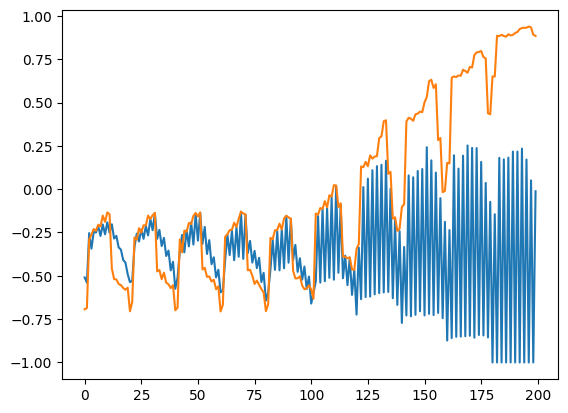

In [42]:
import matplotlib.pyplot as plt

plt.plot(player.Q_sa._Q)
plt.show()

In [44]:
# X, Y = np.meshgrid(range(1, 11), range(12, 22))

# Z = np.zeros_like(X)
# for pt in range(12, 22):
#     for dvs in range(1, 11):
#         Z[dvs-1, pt-12] = player.policy(State(pt+12, dvs+1, True))

# plt.imshow(Z)

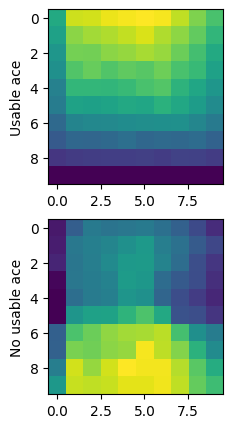

In [45]:
# a = 0
# Z = np.zeros((10,10))
# for pt in range(12, 22):
#     for dvs in range(1,11):
#         Z[dvs-1, pt-12] = player.Q_sa[State(pt, dvs,True), a]

# # Z[dvs,pt]
# plt.imshow(Z)
q_sa = player.Q_sa._Q[:,0].reshape((10,10,2))
fig, ax = plt.subplots(figsize=(10,5), nrows=2)
ax[0].imshow(q_sa[:,:,0])
ax[0].set(ylabel='Usable ace')
ax[1].imshow(q_sa[:,:,1])
ax[1].set(ylabel='No usable ace')
plt.show()

In [46]:
Z = np.zeros((10,10,2), dtype=int)

for s1 in range(10):
    for s2 in range(10):
        for s3 in range(2):
            Z[s1, s2, s3] = player.policy(State(s1+12, s2+1, s3))

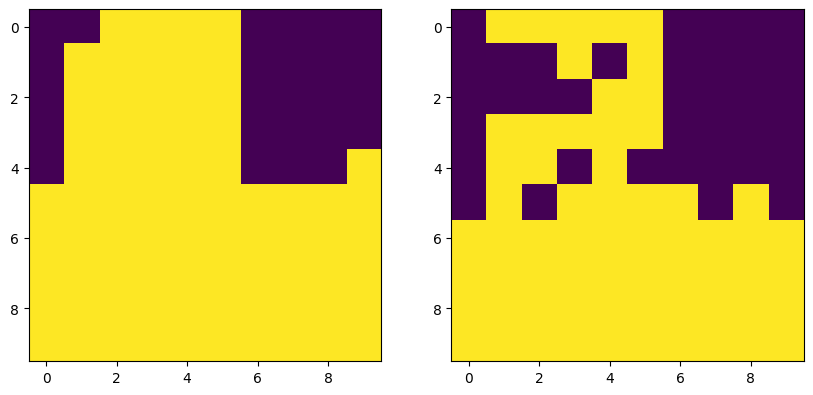

In [47]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].imshow(Z[:,:,0])
ax[1].imshow(Z[:,:,1])

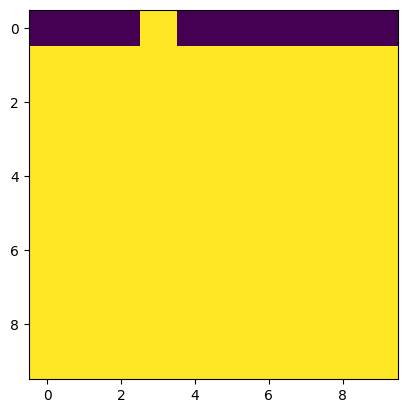

In [38]:
plt.imshow(np.argmax(q_sa, axis=2))